In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates

In [3]:
from financepy.utils import *
from financepy.products.rates import *
from financepy.products.bonds import *

####################################################################
# FINANCEPY BETA Version 0.230 - This build:  30 Aug 2022 at 19:57 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



# OIS data preparation

In [4]:
xls = pd.ExcelFile("Bloomberg - Historical Data v2.03.xlsx")
df = pd.read_excel(xls, sheet_name='gbp ois results')
df.head()

,Unnamed: 0,BPSWS1Z Curncy,Unnamed: 2,BPSWS2Z Curncy,Unnamed: 4,BPSWSA Curncy,Unnamed: 6,BPSWSB Curncy,Unnamed: 8,BPSWSE Curncy,...,Unnamed: 48,BPSWS20 Curncy,Unnamed: 50,BPSWS25 Curncy,Unnamed: 52,BPSWS30 Curncy,Unnamed: 54,BPSWS40 Curncy,Unnamed: 56,BPSWS50 Curncy
0,2022-01-27,0.19560,2022-01-27,0.38050,2022-01-27,0.38050,2022-01-27,0.4339,2022-01-27,0.61670,...,2022-01-27,1.0665,2022-01-27,1.02200,2022-01-27,0.9812,2022-01-27,0.89275,2022-01-27,0.80450
1,2022-01-28,0.22930,2022-01-28,0.38450,2022-01-28,0.38450,2022-01-28,0.4375,2022-01-28,0.63216,...,2022-01-28,1.0938,2022-01-28,1.05250,2022-01-28,1.0158,2022-01-28,0.92410,2022-01-28,0.83600
2,2022-01-31,0.33260,2022-01-31,0.41175,2022-01-31,0.41175,2022-01-31,0.4710,2022-01-31,0.66400,...,2022-01-31,1.1440,2022-01-31,1.10225,2022-01-31,1.0670,2022-01-31,0.98105,2022-01-31,0.89615
3,2022-02-01,0.36900,2022-02-01,0.42165,2022-02-01,0.42165,2022-02-01,0.4770,2022-02-01,0.66610,...,2022-02-01,1.1330,2022-02-01,1.09200,2022-02-01,1.0560,2022-02-01,0.96620,2022-02-01,0.88300
4,2022-02-02,0.40855,2022-02-02,0.43415,2022-02-02,0.43415,2022-02-02,0.4900,2022-02-02,0.67320,...,2022-02-02,1.0960,2022-02-02,1.05100,2022-02-02,1.0110,2022-02-02,0.92025,2022-02-02,0.83355


In [5]:
ticker = pd.read_excel(xls, sheet_name='Ticker')
ticker = pd.DataFrame(ticker, columns=['Term', 'Unit', 'Data Ticker'])
def convert_to_years(row):
    if row['Unit'] == 'WK':
        return row['Term'] / 52
    elif row['Unit'] == 'MO':
        return row['Term'] / 12
    else:
        return row['Term']
ticker['Years'] = ticker.apply(convert_to_years, axis=1)
ticker = pd.DataFrame(ticker, columns=['Years', 'Data Ticker'])
ticker.head()

,Years,Data Ticker
0,0.019231,BPSWS1Z Curncy
1,0.038462,BPSWS2Z Curncy
2,0.083333,BPSWSA Curncy
3,0.166667,BPSWSB Curncy
4,0.250000,BPSWSC Curncy


In [6]:
dates_columns = [col for col in df.columns if col.startswith('Unnamed')]
swaps_columns = [col for col in df.columns if col not in dates_columns]

# Find the common dates
common_dates = set(df[dates_columns[0]])

for column in dates_columns[1:]:
    common_dates = common_dates.intersection(set(df[column]))

In [7]:
# Iterate over the columns and split into separate DataFrames
dfs = []
for i in range(0, len(df.columns), 2):
    sub_df = df.iloc[:, i:i+2].copy()
    sub_df.columns = ['Date', df.columns[i+1]]
    dfs.append(sub_df)

# Filter each DataFrame based on common dates
filtered_dfs = []
for sub_df in dfs:
    filtered_df = sub_df[sub_df['Date'].isin(common_dates)]
    filtered_dfs.append(filtered_df)

In [8]:
merged_df = filtered_dfs[0]
for df in filtered_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='Date')

# Print the merged DataFrame
merged_df.head()

,Date,BPSWS1Z Curncy,BPSWS2Z Curncy,BPSWSA Curncy,BPSWSB Curncy,BPSWSE Curncy,BPSWSF Curncy,BPSWSG Curncy,BPSWSH Curncy,BPSWSI Curncy,...,BPSWS8 Curncy,BPSWS9 Curncy,BPSWS10 Curncy,BPSWS12 Curncy,BPSWS15 Curncy,BPSWS20 Curncy,BPSWS25 Curncy,BPSWS30 Curncy,BPSWS40 Curncy,BPSWS50 Curncy
0,2022-01-27,0.19560,0.38050,0.38050,0.4339,0.61670,0.6738,0.7420,0.79440,0.84270,...,1.18400,1.17000,1.15820,1.1314,1.1148,1.0665,1.02200,0.9812,0.89275,0.80450
1,2022-01-28,0.22930,0.38450,0.38450,0.4375,0.63216,0.6910,0.7589,0.81300,0.86277,...,1.20635,1.19205,1.18135,1.1593,1.1387,1.0938,1.05250,1.0158,0.92410,0.83600
2,2022-01-31,0.33260,0.41175,0.41175,0.4710,0.66400,0.7230,0.7967,0.85310,0.90340,...,1.25550,1.23790,1.22800,1.2130,1.1860,1.1440,1.10225,1.0670,0.98105,0.89615
3,2022-02-01,0.36900,0.42165,0.42165,0.4770,0.66610,0.7255,0.7940,0.85360,0.89930,...,1.24800,1.23400,1.22400,1.2038,1.1779,1.1330,1.09200,1.0560,0.96620,0.88300
4,2022-02-02,0.40855,0.43415,0.43415,0.4900,0.67320,0.7258,0.7908,0.84631,0.89184,...,1.22300,1.20800,1.19700,1.1750,1.1470,1.0960,1.05100,1.0110,0.92025,0.83355


In [9]:
tenor = pd.read_excel(xls, sheet_name='Ticker')
tenor = pd.DataFrame(tenor, columns=['Term', 'Unit', 'Data Ticker'])
tenor = tenor[tenor['Data Ticker'].isin(merged_df.columns.to_list())].reset_index(drop=True)
def convert_to_tenor(row):
    if row['Unit'] == 'WK':
        return str(row['Term']) + 'W'
    elif row['Unit'] == 'MO':
        return str(row['Term']) + 'M'
    else:
        return str(row['Term']) + 'Y'
tenor['Tenor'] = tenor.apply(convert_to_tenor, axis=1)
tenor = pd.DataFrame(tenor, columns=['Tenor', 'Data Ticker'])
tenor.set_index('Data Ticker', inplace=True)
tenor.head()

,Tenor
Data Ticker,
BPSWS1Z Curncy,1W
BPSWS2Z Curncy,2W
BPSWSA Curncy,1M
BPSWSB Curncy,2M
BPSWSE Curncy,5M


# OIS curve

In [10]:
corresponding_years = []
for column_name in merged_df.columns:
    # Check if column name appears in 'Data Ticker' column of ticker dataframe
    ticker_row = ticker[ticker['Data Ticker'] == column_name]
    if not ticker_row.empty:
        # Extract corresponding 'Years' value
        years_value = ticker_row.iloc[0]['Years']
        corresponding_years.append(years_value)

In [11]:
spot_days = 0
swapType = SwapTypes.PAY
fixedDCCType = DayCountTypes.ACT_365F
fixedFreqType = FrequencyTypes.ANNUAL

ois_curves = {}

# fit OIS curve for each day
for date in merged_df.Date:
    
    valuation_date = Date(date.day,date.month,date.year)
    settlement_date = valuation_date.add_weekdays(spot_days)
    
    swaps = []
    for product in merged_df.columns[1:]:
        swap = OIS(settlement_date, tenor.loc[product,'Tenor'], swapType, merged_df[merged_df['Date']==date][product].values[0]/100, fixedFreqType, fixedDCCType); swaps.append(swap)
    oisCurveLZ = OISCurve(valuation_date, [], [], swaps, InterpTypes.LINEAR_ZERO_RATES)
    
    ois_curves.update({date:oisCurveLZ})

the valuation date is:  2022-06-23 00:00:00


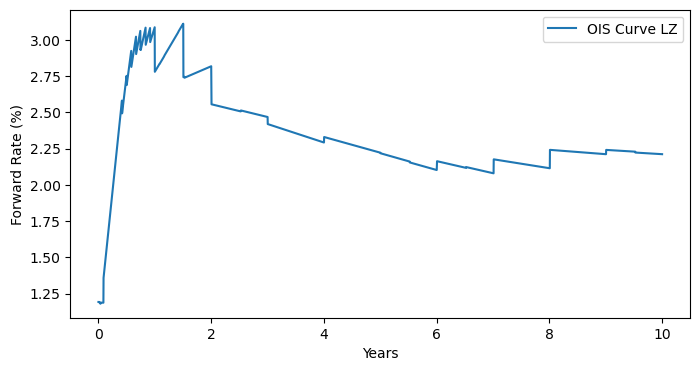

In [12]:
# plot a sample

date = merged_df.iloc[100,0]
print('the valuation date is: ',date)
valuation_date = Date(date.day,date.month,date.year)
settlement_date = valuation_date.add_weekdays(spot_days)

years = np.linspace(0, 10, 10*365)
dates = settlement_date.add_years(years)  
oisCurveFwds = ois_curves[date].fwd(dates)    

plt.figure(figsize=(8,4))
plt.plot(years, oisCurveFwds*100.0, label="OIS Curve LZ")
plt.xlabel("Years")
plt.ylabel("Forward Rate (%)")
plt.legend();

# Bond data preparation

In [13]:
b_info = pd.read_excel('Gilts_Historical_Data_2020_2023.xlsx', sheet_name='STATIC')
b_info.dropna(axis=0,inplace=True)
b_info['maturity_date']=pd.to_datetime(b_info['maturity_date'],format="%YYYY-%mm-%dd")
b_info['issue_date']=pd.to_datetime(b_info['issue_date'],format="%YYYY-%mm-%dd")
b_info.set_index('instrument_id',inplace=True)
b_info.head()

,bond_type_id,ticker,description,maturity_date,coupon,issue_date
instrument_id,,,,,,
GB00BMGR2791,GILT,UKT,UKT 0.125 31/01/24,2024-01-31,0.00125,2020-10-07
GB00BFWFPL34,GILT,UKT,UKT 1 22/04/24,2024-04-22,0.01000,2018-07-17
GB00BHBFH458,GILT,UKT,UKT 2.75 07/09/24,2024-09-07,0.02750,2014-03-04
GB00BLPK7110,GILT,UKT,UKT 0.25 31/01/25,2025-01-31,0.00250,2021-06-23
GB0030880693,GILT,UKT,UKT 5 07/03/25,2025-03-07,0.05000,2004-12-13


In [14]:
df = pd.read_excel('Gilts_Historical_Data_2020_2023.xlsx', sheet_name='HIST_PRICE')
df['eod_date'] = pd.to_datetime(df['eod_date'],format="%YYYY-%mm-%dd")
df.set_index('eod_date',inplace=True)
df = df[df.index.isin(merged_df.Date)]
df.dropna(how='any',axis=1,inplace=True)
df.head()

,GB0002404191,GB0004893086,GB0030880693,GB0032452392,GB00B00NY175,GB00B06YGN05,GB00B128DP45,GB00B16NNR78,GB00B1VWPJ53,GB00B24FF097,...,GB00BMGR2791,GB00BMGR2809,GB00BMGR2916,GB00BN65R313,GB00BNNGP668,GB00BNNGP775,GB00BTHH2R79,GB00BYYMZX75,GB00BYZW3G56,GB00BZB26Y51
eod_date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,1.32385,1.29010,1.12229,1.37410,1.51078,1.79839,1.59385,1.18070,1.55943,1.30151,...,0.98350,0.91230,0.90767,1.40747,0.96821,0.89008,1.03632,1.44296,1.02261,1.05036
2022-01-28,1.32289,1.28829,1.12183,1.37142,1.50852,1.79315,1.58915,1.18017,1.55563,1.29995,...,0.98342,0.91141,0.90582,1.40343,0.96828,0.88702,1.03606,1.43744,1.02242,1.04831
2022-01-31,1.31774,1.28109,1.11937,1.35949,1.49290,1.75863,1.56622,1.17592,1.53743,1.29365,...,0.98196,0.90602,0.89708,1.38370,0.96521,0.87148,1.03343,1.39985,1.01932,1.03727
2022-02-01,1.31695,1.28101,1.11886,1.36140,1.49566,1.76516,1.57080,1.17523,1.54073,1.29356,...,0.98157,0.90604,0.89812,1.38834,0.96486,0.87464,1.03294,1.40681,1.01892,1.03910
2022-02-02,1.32095,1.28700,1.12007,1.37182,1.50886,1.79733,1.59328,1.17789,1.55849,1.29875,...,0.98243,0.91067,0.90629,1.40771,0.96674,0.88997,1.03439,1.44202,1.02069,1.04899


# Fit NSS-model to z-spreads

To answer this question, we mainly follow the procedure of FinancePy/notebooks/products/bonds/FINBONDYIELDCURVE_FittingToAswAndZSpreads.ipynb
https://github.com/piterbarg/FinancePy/tree/5c9ba8427716e899eef6aa4fb1e66be75a088742/notebooks/products/bonds

## Z-spreads calculation

In [15]:
# SPECIFY UK BOND CONVENTIONS
frequencyType = FrequencyTypes.SEMI_ANNUAL

accrual_type = DayCountTypes.ACT_ACT_ICMA

In [16]:
cal = CalendarTypes.UNITED_KINGDOM

# initiate empty z-spreads dataframe
z_spreads = pd.DataFrame(columns=df.columns,
                         index = df.index)

# initiate empty dataframe to save fitted parameters and curve
betas = pd.DataFrame(columns=['beta1','beta2','beta3','beta4'],
                     index=df.index)

# initiate empty disctionary to save fitted curves
fitted_curves = {}

In [17]:
# LOAD BONDS AND CREATE A VECTOR OF FINBOND AND THEIR CORRESPONDING z-spreads
# THEN FIT NSS MODEL

curveFitMethod = CurveFitNelsonSiegelSvensson() 
date_list = df.index.intersection(ois_curves.keys())

for date in date_list:
    bonds = []
    settlement = Date(date.day, date.month,date.year)
    for bid in df.columns:
        matDatetime = b_info.loc[bid,'maturity_date']
        maturityDt = from_datetime(matDatetime)
        coupon = b_info.loc[bid,'coupon']
        clean_price = df.loc[date,bid]*100.
        issue_date = from_datetime(b_info.loc[bid,'issue_date'])
        bond = Bond(issue_date, maturityDt, coupon, frequencyType, accrual_type)     
        z_spread = bond.z_spread(settlement, clean_price, ois_curves[date])
        bonds.append(bond)  
        # update z-spread data
        z_spreads.loc[date,bid] = z_spread

    # fit NSS model
    z_spread_input=z_spreads.loc[date,:].tolist()
    fittedCurve4z = BondYieldCurve(settlement, bonds, z_spread_input, curveFitMethod)
    # update fitted curve data
    fitted_curves.update({date:fittedCurve4z})
    betas.loc[date,'beta1'] = fittedCurve4z._curveFit._beta1
    betas.loc[date,'beta2'] = fittedCurve4z._curveFit._beta2
    betas.loc[date,'beta3'] = fittedCurve4z._curveFit._beta3
    betas.loc[date,'beta4'] = fittedCurve4z._curveFit._beta4

In [18]:
z_spreads

,GB0002404191,GB0004893086,GB0030880693,GB0032452392,GB00B00NY175,GB00B06YGN05,GB00B128DP45,GB00B16NNR78,GB00B1VWPJ53,GB00B24FF097,...,GB00BMGR2791,GB00BMGR2809,GB00BMGR2916,GB00BN65R313,GB00BNNGP668,GB00BNNGP775,GB00BTHH2R79,GB00BYYMZX75,GB00BYZW3G56,GB00BZB26Y51
eod_date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,-0.001193,0.000973,-0.002877,0.00205,0.002435,0.003367,0.003647,-0.001667,0.003228,-0.000156,...,-0.002761,0.000708,0.002561,0.003612,-0.001968,0.003864,-0.003089,0.002966,-0.002822,0.002789
2022-01-28,-0.001318,0.00089,-0.003054,0.001971,0.0023,0.003182,0.003524,-0.001855,0.003116,-0.000228,...,-0.00303,0.000592,0.002464,0.003496,-0.002211,0.003731,-0.003295,0.002791,-0.003024,0.00269
2022-01-31,-0.001168,0.001036,-0.003077,0.002242,0.002619,0.003536,0.003851,-0.001676,0.003385,-0.000075,...,-0.002908,0.000777,0.00272,0.003823,-0.002022,0.004065,-0.00321,0.003127,-0.002862,0.002986
2022-02-01,-0.001048,0.001085,-0.002889,0.002193,0.002556,0.003481,0.003781,-0.00155,0.003342,-0.000031,...,-0.00257,0.000816,0.002718,0.003726,-0.001924,0.003999,-0.003034,0.003092,-0.002751,0.00294
2022-02-02,-0.001351,0.00081,-0.00304,0.001806,0.002183,0.003092,0.003355,-0.001775,0.002943,-0.00032,...,-0.002786,0.000538,0.002314,0.003291,-0.002121,0.003587,-0.003204,0.002707,-0.002934,0.002561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,-0.000116,0.001857,-0.002899,0.004266,0.005741,0.007883,0.007643,-0.000834,0.007117,0.001321,...,-0.007885,0.001824,0.004225,0.007587,-0.001829,0.007137,-0.003044,0.007843,-0.002625,0.005365
2024-01-02,-0.000042,0.001904,-0.002513,0.004114,0.005566,0.007724,0.007424,-0.000681,0.006927,0.001392,...,-0.003367,0.001917,0.004033,0.007339,-0.001556,0.006908,-0.002662,0.007662,-0.00237,0.005174
2024-01-03,0.0007,0.002504,-0.001947,0.004606,0.006121,0.00835,0.007999,0.000235,0.007454,0.001938,...,-0.002718,0.002455,0.004542,0.007985,-0.000669,0.00749,-0.001922,0.008225,-0.001523,0.005568


valuation date:  2024-01-05 00:00:00


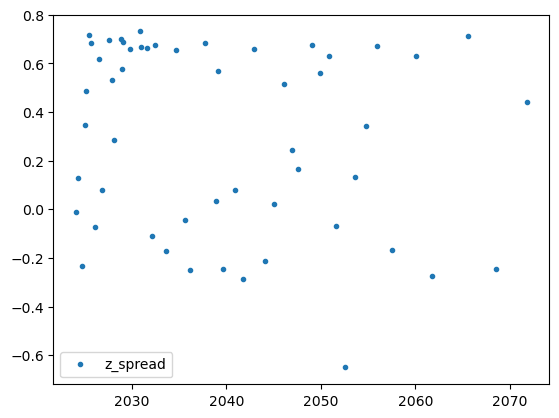

In [19]:
d_string = '2024-01-05'
sample_date = pd.to_datetime(d_string,format="%Y-%m-%d")
print('valuation date: ',sample_date)
plt.plot(b_info.loc[:,'maturity_date'], np.array(z_spreads.loc[sample_date,:])*100, '.', label='z_spread')
plt.legend(loc='best')
plt.show()

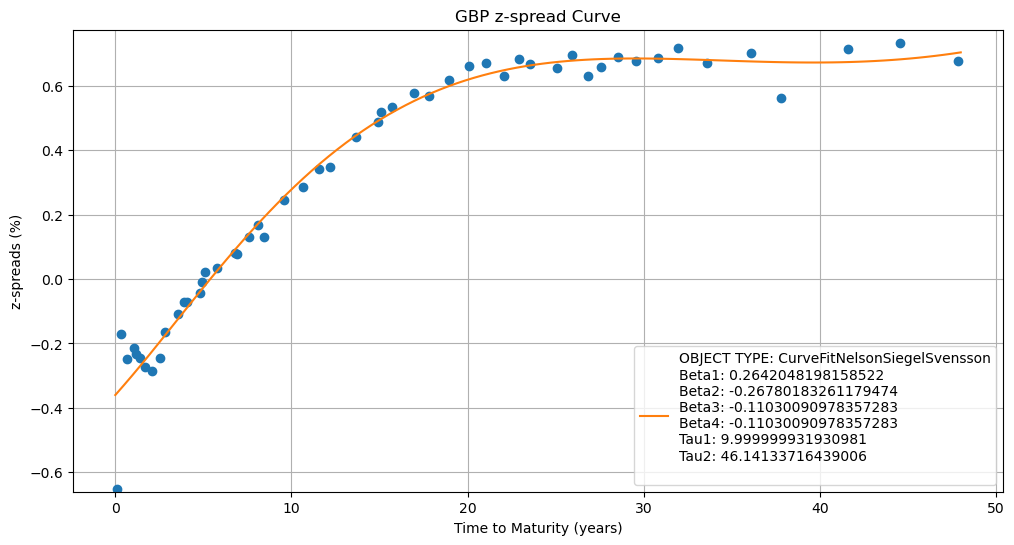

In [20]:
# plot NSS fitting sample
fitted_curves[sample_date].plot("GBP z-spread Curve", ylabel = 'z-spreads (%)')

# Compute and analyse z-scores 

In [21]:
betas
# NSS only has 3 betas - meaning of these betas?

,beta1,beta2,beta3,beta4
eod_date,,,,
2022-01-27,0.011374,-0.01044,-0.027851,-0.037249
2022-01-28,0.011244,-0.010238,-0.028716,-0.037093
2022-01-31,0.011905,-0.011255,-0.028481,-0.038003
2022-02-01,0.011211,-0.009511,-0.029141,-0.036279
2022-02-02,0.010567,-0.009304,-0.027953,-0.03493
...,...,...,...,...
2023-12-29,0.262542,-0.267268,-0.101987,-0.665241
2024-01-02,0.095903,-0.098624,-0.058812,-0.239325
2024-01-03,0.252482,-0.254798,-0.115536,-0.643452


In [22]:
mu = betas.mean()
std = betas.std()
z_scores = (betas - mu) / std
z_scores

,beta1,beta2,beta3,beta4
eod_date,,,,
2022-01-27,-0.867673,0.904671,1.029862,0.825685
2022-01-28,-0.868879,0.906495,1.005966,0.826238
2022-01-31,-0.862743,0.897305,1.012456,0.823018
2022-02-01,-0.869179,0.913075,0.994228,0.829118
2022-02-02,-0.875158,0.914944,1.027024,0.833889
...,...,...,...,...
2023-12-29,1.461713,-1.41782,-1.017111,-1.395919
2024-01-02,-0.083736,0.107231,0.174982,0.110814
2024-01-03,1.368411,-1.30505,-1.391234,-1.318838


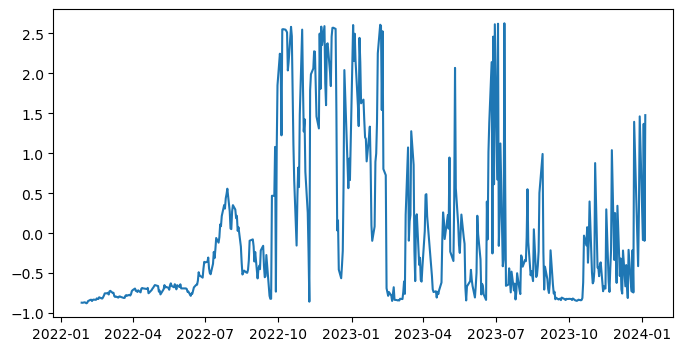

In [23]:
plt.figure(figsize=(8,4))
plt.plot(z_scores.index,z_scores['beta1'])
plt.show()

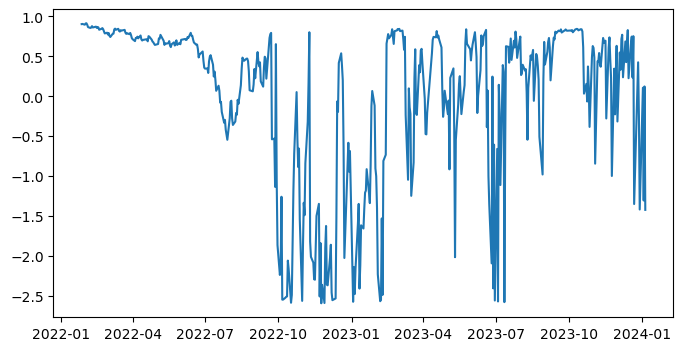

In [24]:
plt.figure(figsize=(8,4))
plt.plot(z_scores.index,z_scores['beta2'])
plt.show()

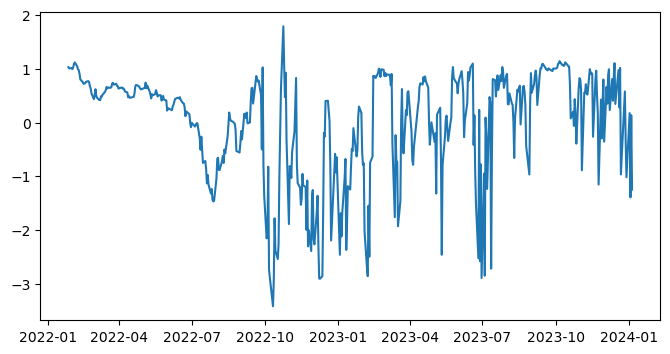

In [25]:
plt.figure(figsize=(8,4))
plt.plot(z_scores.index,z_scores['beta3'])
plt.show()

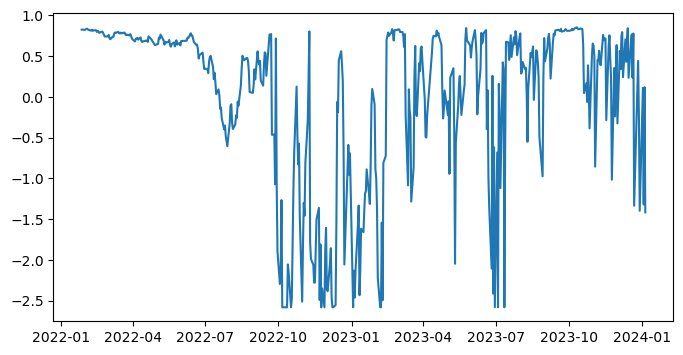

In [26]:
plt.figure(figsize=(8,4))
plt.plot(z_scores.index,z_scores['beta4'])
plt.show()

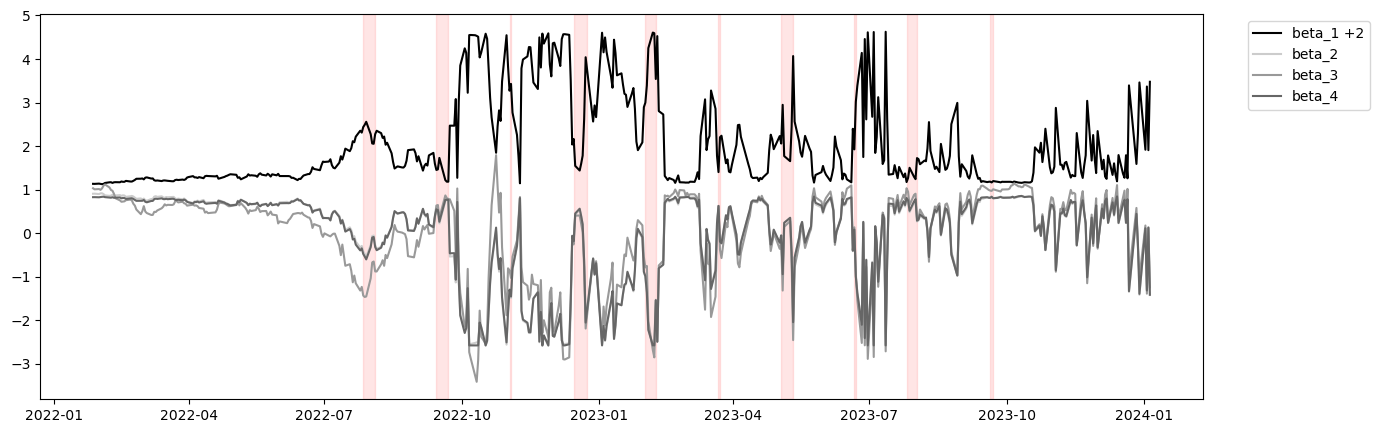

In [27]:
# rate adjustment events

plt.figure(figsize=(15,5))
plt.plot(z_scores.index,z_scores['beta1']+2,color='k',label='beta_1 +2')
plt.plot(z_scores.index,z_scores['beta2'],color='#CCCCCC',label='beta_2')
plt.plot(z_scores.index,z_scores['beta3'],color='#999999',label='beta_3')
plt.plot(z_scores.index,z_scores['beta4'],color='#666666',label='beta_4')

# Fed 0727 BOE 0804 ECB 0727
date_1 = pd.to_datetime('2022-07-27',format="%Y-%m-%d")
date_2 = pd.to_datetime('2022-08-04',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# Fed 0921 BOE 0922 ECB 0914
date_1 = pd.to_datetime('2022-09-14',format="%Y-%m-%d")
date_2 = pd.to_datetime('2022-09-22',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# Fed 1102 BOE 1103 ECB 1102
date_1 = pd.to_datetime('2022-11-02',format="%Y-%m-%d")
date_2 = pd.to_datetime('2022-11-03',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# Fed 1224 BOE 1215 ECB 1221
date_1 = pd.to_datetime('2022-12-15',format="%Y-%m-%d")
date_2 = pd.to_datetime('2022-12-24',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# Fed 0201 BOE 0202 ECB 0208
date_1 = pd.to_datetime('2023-02-01',format="%Y-%m-%d")
date_2 = pd.to_datetime('2023-02-08',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# Fed 0322 BOE 0323 ECB 0322
date_1 = pd.to_datetime('2023-03-22',format="%Y-%m-%d")
date_2 = pd.to_datetime('2023-03-23',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# Fed 0503 BOE 0511 ECB 0510
date_1 = pd.to_datetime('2023-05-03',format="%Y-%m-%d")
date_2 = pd.to_datetime('2023-05-11',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# BOE 0622 ECB 0621
date_1 = pd.to_datetime('2023-06-21',format="%Y-%m-%d")
date_2 = pd.to_datetime('2023-06-22',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# Fed 0726 ECB 0802
date_1 = pd.to_datetime('2023-07-26',format="%Y-%m-%d")
date_2 = pd.to_datetime('2023-08-02',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
# BOE 0922 ECB 0920
date_1 = pd.to_datetime('2023-09-20',format="%Y-%m-%d")
date_2 = pd.to_datetime('2023-09-22',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)

plt.legend(bbox_to_anchor=(1.15, 1),loc='upper right')
plt.show()

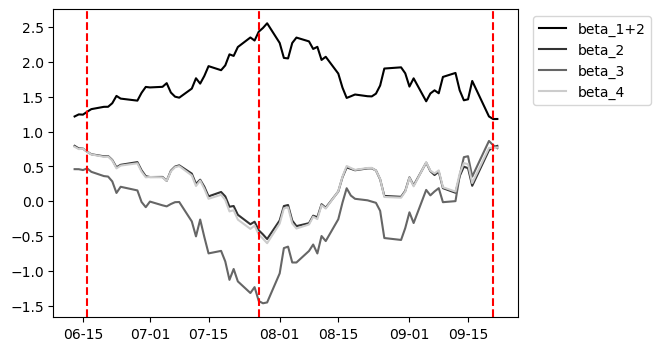

In [28]:
# Fed Rate Hikes 2022.6.13-2022.9.22
start = pd.to_datetime('2022-06-13',format="%Y-%m-%d")
end = pd.to_datetime('2022-09-22',format="%Y-%m-%d")
z_new = z_scores.loc[start:end]
plt.figure(figsize=(6,4))
plt.plot(z_new.index,z_new['beta1']+2,color='k',label='beta_1+2')
plt.plot(z_new.index,z_new['beta2'],color='#333333',label='beta_2')
plt.plot(z_new.index,z_new['beta3'],color='#666666',label='beta_3')
plt.plot(z_new.index,z_new['beta4'],color='#CCCCCC',label='beta_4')
date_1 = pd.to_datetime('2022-06-16',format="%Y-%m-%d") # first +75bp
plt.axvline(x=date_1, color='red', linestyle='--')
date_2 = pd.to_datetime('2022-07-27',format="%Y-%m-%d") # +75bp
plt.axvline(x=date_2, color='red', linestyle='--')
date_3 = pd.to_datetime('2022-09-21',format="%Y-%m-%d")# +75bp
plt.axvline(x=date_3, color='red', linestyle='--')
date_format = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.show()

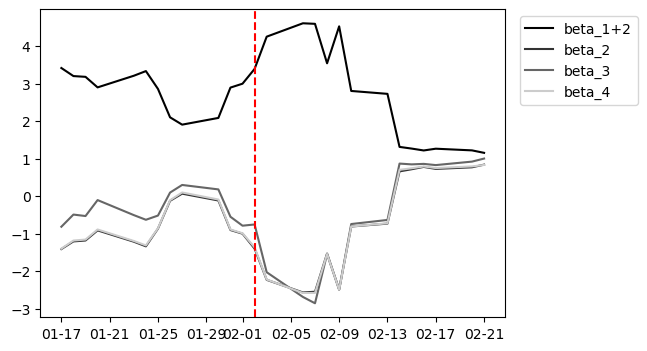

In [29]:
# ECB + Fed + BOE 2023.1.17-2023.2.21
start = pd.to_datetime('2023-01-17',format="%Y-%m-%d")
end = pd.to_datetime('2023-02-21',format="%Y-%m-%d")
z_new = z_scores.loc[start:end]
plt.figure(figsize=(6,4))
plt.plot(z_new.index,z_new['beta1']+2,color='k',label='beta_1+2')
plt.plot(z_new.index,z_new['beta2'],color='#333333',label='beta_2')
plt.plot(z_new.index,z_new['beta3'],color='#666666',label='beta_3')
plt.plot(z_new.index,z_new['beta4'],color='#CCCCCC',label='beta_4')
date_1 = pd.to_datetime('2023-02-02',format="%Y-%m-%d") 
# The European Central Bank and Bank of England raise their interest rates by 50bp to combat inflation,
# one day after the US Federal Reserve raises its federal funds rate by 25 bp
plt.axvline(x=date_1, color='red', linestyle='--')
date_format = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.show()

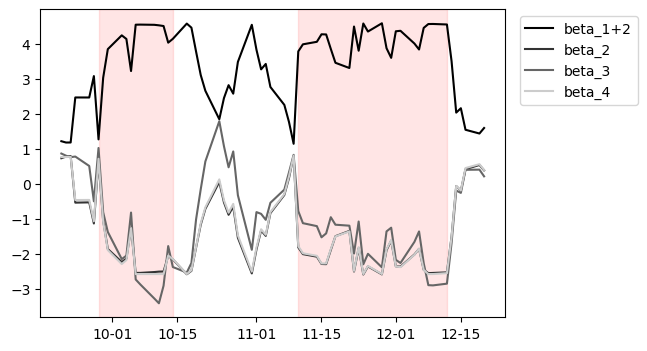

In [30]:
# uk pension fund crisis + crypto crisis 2022.9.20 - 2022.12.20
start = pd.to_datetime('2022-09-20',format="%Y-%m-%d")
end = pd.to_datetime('2022-12-20',format="%Y-%m-%d")
z_new = z_scores.loc[start:end]
plt.figure(figsize=(6,4))
plt.plot(z_new.index,z_new['beta1']+2,color='k',label='beta_1+2')
plt.plot(z_new.index,z_new['beta2'],color='#333333',label='beta_2')
plt.plot(z_new.index,z_new['beta3'],color='#666666',label='beta_3')
plt.plot(z_new.index,z_new['beta4'],color='#CCCCCC',label='beta_4')
date_1 = pd.to_datetime('2022-09-28',format="%Y-%m-%d")
date_2 = pd.to_datetime('2022-10-14',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1) # UK pension fund crisis: temporary gilt purchase program
date_3 = pd.to_datetime('2022-11-10',format="%Y-%m-%d")
date_4 = pd.to_datetime('2022-12-12',format="%Y-%m-%d")
plt.axvspan(date_3, date_4, color='red', alpha=0.1) # LTX-crypto crisis
date_format = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.show()

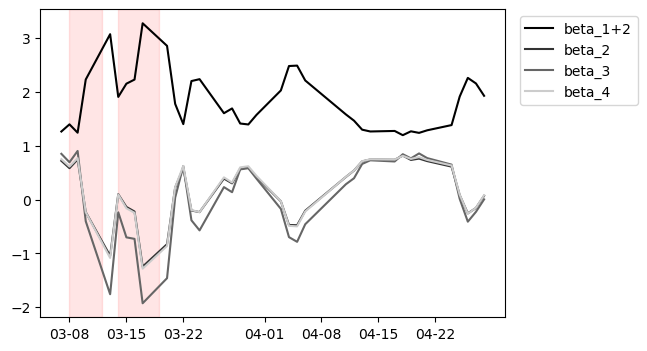

In [31]:
# Banking crisis 2023
start = pd.to_datetime('2023-03-07',format="%Y-%m-%d")
end = pd.to_datetime('2023-05-01',format="%Y-%m-%d")
z_new = z_scores.loc[start:end]
plt.figure(figsize=(6,4))
plt.plot(z_new.index,z_new['beta1']+2,color='k',label='beta_1+2')
plt.plot(z_new.index,z_new['beta2'],color='#333333',label='beta_2')
plt.plot(z_new.index,z_new['beta3'],color='#666666',label='beta_3')
plt.plot(z_new.index,z_new['beta4'],color='#CCCCCC',label='beta_4')
date_1 = pd.to_datetime('2023-03-08',format="%Y-%m-%d")
date_2 = pd.to_datetime('2023-03-12',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1) # US bank failures
date_3 = pd.to_datetime('2023-03-14',format="%Y-%m-%d")
date_4 = pd.to_datetime('2023-03-19',format="%Y-%m-%d")
plt.axvspan(date_3, date_4, color='red', alpha=0.1) # credit suisse -> acquisition
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
date_format = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

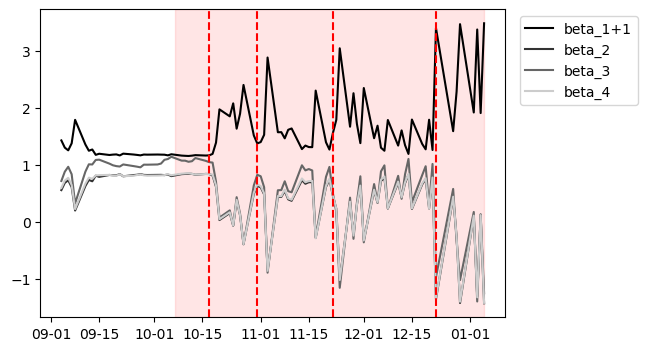

In [32]:
# gaza
start = pd.to_datetime('2023-09-03',format="%Y-%m-%d")
end = pd.to_datetime('2024-01-05',format="%Y-%m-%d")
z_new = z_scores.loc[start:end]
plt.figure(figsize=(6,4))
plt.plot(z_new.index,z_new['beta1']+2,color='k',label='beta_1+1')
plt.plot(z_new.index,z_new['beta2'],color='#333333',label='beta_2')
plt.plot(z_new.index,z_new['beta3'],color='#666666',label='beta_3')
plt.plot(z_new.index,z_new['beta4'],color='#CCCCCC',label='beta_4')
date_1 = pd.to_datetime('2023-10-07',format="%Y-%m-%d")
date_2 = pd.to_datetime('2024-01-05',format="%Y-%m-%d")
plt.axvspan(date_1, date_2, color='red', alpha=0.1)
date_3 = pd.to_datetime('2023-10-17',format="%Y-%m-%d") # An explosion occurs at the Al-Ahli Arab Hospital
plt.axvline(x=date_3, color='red', linestyle='--')
date_4 = pd.to_datetime('2023-10-31',format="%Y-%m-%d") # Israel intercepted a Yemeni Houthi ballistic missile with its Arrow 2 missile defense system
plt.axvline(x=date_4, color='red', linestyle='--')
date_5 = pd.to_datetime('2023-11-22',format="%Y-%m-%d") # 4-day cease fire
plt.axvline(x=date_5, color='red', linestyle='--')
date_6 = pd.to_datetime('2023-12-22',format="%Y-%m-%d") # The death toll in Gaza is reported to have passed 20,000
plt.axvline(x=date_6, color='red', linestyle='--')
date_format = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.show()

# Mean Reverting and Trending on $\beta$

## Regression of $\Delta \beta$ on $\beta$

In [33]:
def regress_dx_on_x(paths):
    '''
    calculate regr coeff dx ~ mean + slope x for each path (ie row of the paths matrix)
    annualize the results
    '''
    dt = 1.0/250

    dx = np.diff(paths, axis=1)
    x = paths[:,:-1]

    npaths = x.shape[0]
    slope = np.zeros(x.shape[0])
    const_coef = np.ones(x.shape[1])
    for n in range(npaths):
        lhs = np.vstack((const_coef, x[n,:])).T
        sol = np.linalg.lstsq(lhs.astype('float'), dx[n,:].astype('float'), rcond=None)
        slope[n] = sol[0][1]/dt

    slope_z_score = (slope - 0)/slope.std()
    return slope, slope_z_score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


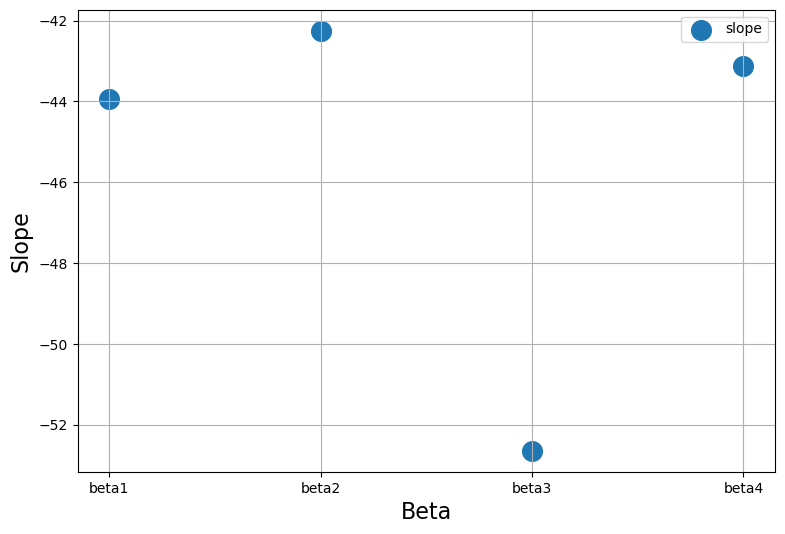

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


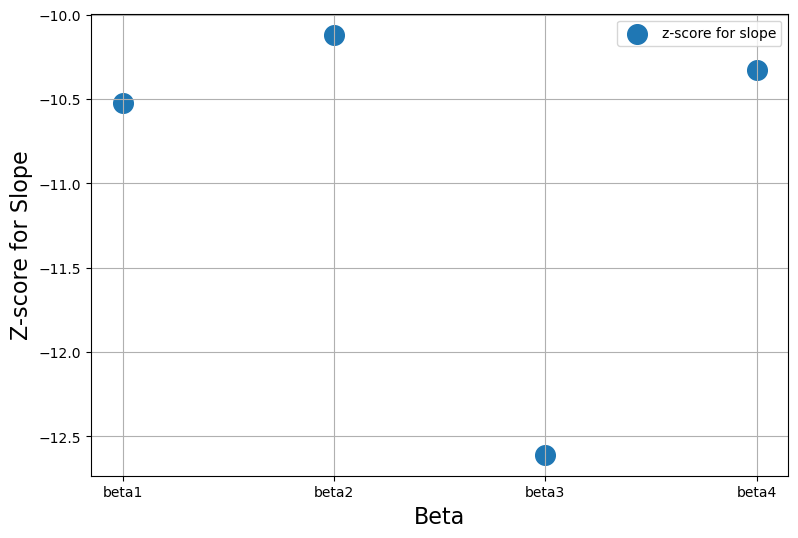

In [34]:
test_res = regress_dx_on_x(paths = np.array(betas).transpose())

plt.figure(figsize=(9, 6))
plt.grid(True)
plt.scatter(range(1, 5), test_res[0][:], label='slope', marker='o', s=200)
plt.xticks(range(1, 5), [f'beta{i}' for i in range(1, 5)])  # Change x-axis labels
plt.xlabel('Beta', fontsize=16)
plt.ylabel('Slope', fontsize=16)
plt.legend(loc='best')
plt.savefig('slope.eps', format='eps')
plt.show()

plt.figure(figsize=(9, 6))
plt.grid(True)
plt.scatter(range(1, 5), test_res[1][:], label='z-score for slope', marker='o', s=200)
plt.xticks(range(1, 5), [f'beta{i}' for i in range(1, 5)])  # Change x-axis labels
plt.xlabel('Beta', fontsize=16)
plt.ylabel('Z-score for Slope', fontsize=16)
plt.legend(loc='best')
plt.savefig('zscore_for_slope.eps', format='eps')
plt.show()

In [35]:
test_res[0].mean(),test_res[1].mean()

(-45.49082050681719, -10.895055626214452)

## Investigate the ADF method for detecting mean-reversion

In [36]:
adf_max_lag = 1
adf_regr_params = 'c'
adf_stat = np.zeros(4)
adf_pval = np.zeros(4)
for n in range(4):
    res = adfuller(np.array(betas).transpose()[n], maxlag=adf_max_lag, regression=adf_regr_params)
    adf_stat[n] = res[0]
    adf_pval[n] = res[1]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


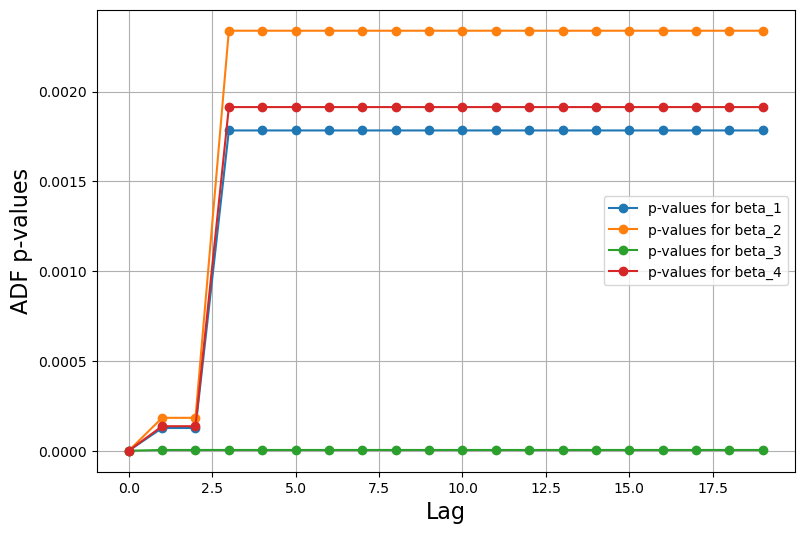

In [37]:
adf_stat_lag = np.zeros((4,20))
adf_pval_lag = np.zeros((4,20))

plt.figure(figsize=(9, 6))
plt.grid(True)
for n in range(4):
    for i in range(20):
        res = adfuller(np.array(betas).transpose()[n], maxlag=i)
        adf_stat_lag[n,i] = res[0]
        adf_pval_lag[n,i] = res[1]
    plt.plot(adf_pval_lag[n,:], label = f'p-values for beta_{n+1}', marker = 'o')

plt.xlabel('Lag', fontsize=16)
plt.ylabel('ADF p-values', fontsize=16)
plt.legend(loc = 'best')
plt.savefig('adf_lag.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


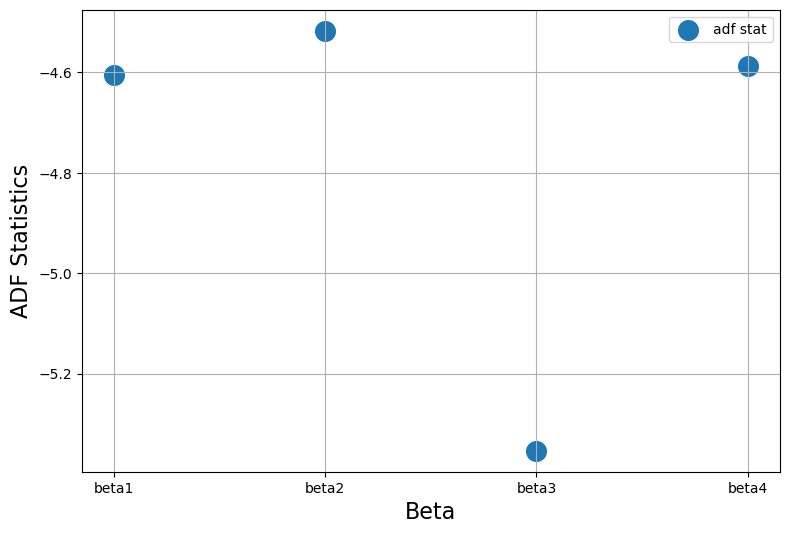

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


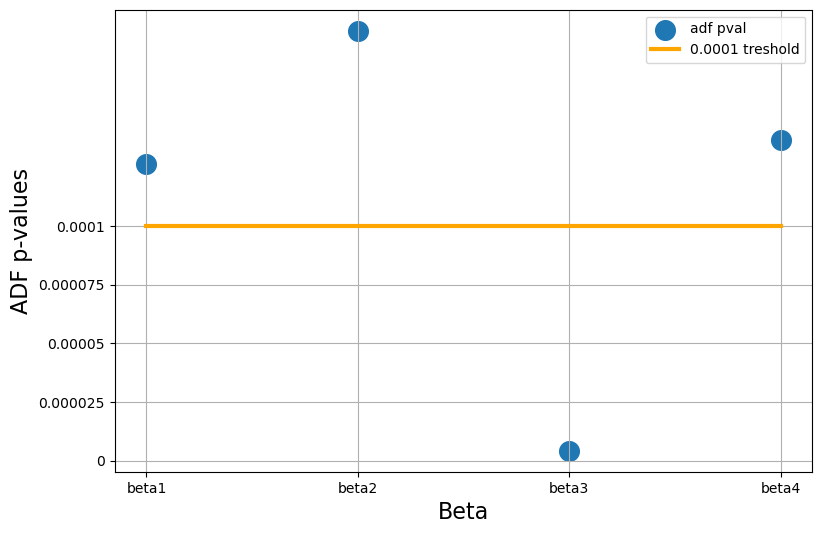

Percentage of significance: 1.0


In [38]:
plt.figure(figsize=(9, 6))
plt.grid(True)
plt.scatter(range(1, 5),adf_stat, label = 'adf stat', marker='o', s=200)
plt.xticks(range(1, 5), [f'beta{i}' for i in range(1, 5)])
plt.xlabel('Beta', fontsize=16)
plt.ylabel('ADF Statistics', fontsize=16)
plt.legend(loc = 'best')
plt.savefig('adf_stat.eps', format='eps')
plt.show()

plt.figure(figsize=(9, 6))
plt.grid(True)
plt.scatter(range(1, 5),adf_pval, label = 'adf pval', marker='o', s=200)
plt.plot(range(1, 5),np.ones_like(adf_pval[:])*0.0001, color='orange', label = '0.0001 treshold', linewidth=3)
plt.xticks(range(1, 5), [f'beta{i}' for i in range(1, 5)]) 
plt.yticks([0, 0.000025, 0.00005, 0.000075, 0.0001], ['0', '0.000025', '0.00005', '0.000075', '0.0001'])
plt.xlabel('Beta', fontsize=16)
plt.ylabel('ADF p-values', fontsize=16)
plt.legend(loc = 'best')
plt.savefig('adf_pval.eps', format='eps')
plt.show()
print("Percentage of significance:",sum(adf_pval < 0.05)/len(adf_pval))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


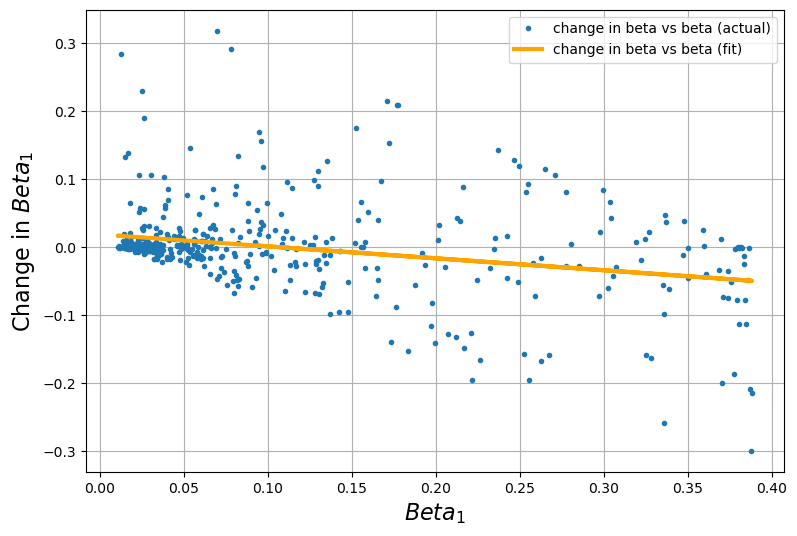

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-43.93529642109549
adf p-value= 0.00012643410276660393


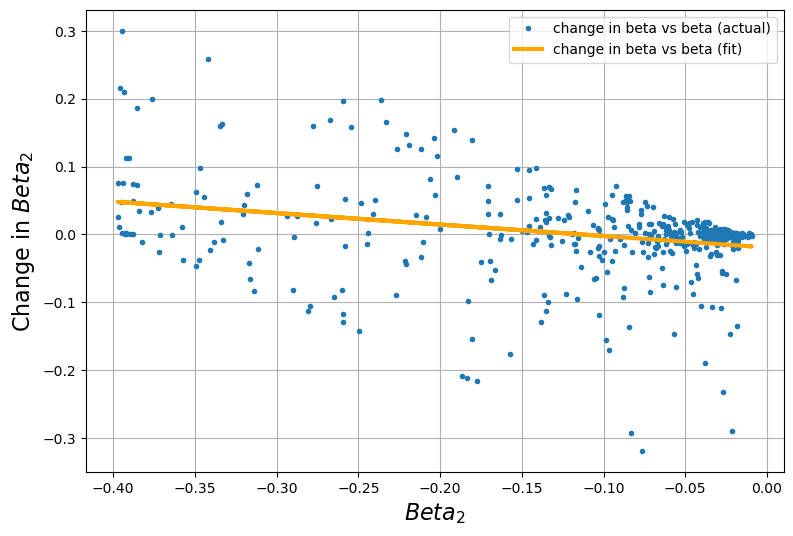

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-42.24861077848563
adf p-value= 0.00018318369999408682


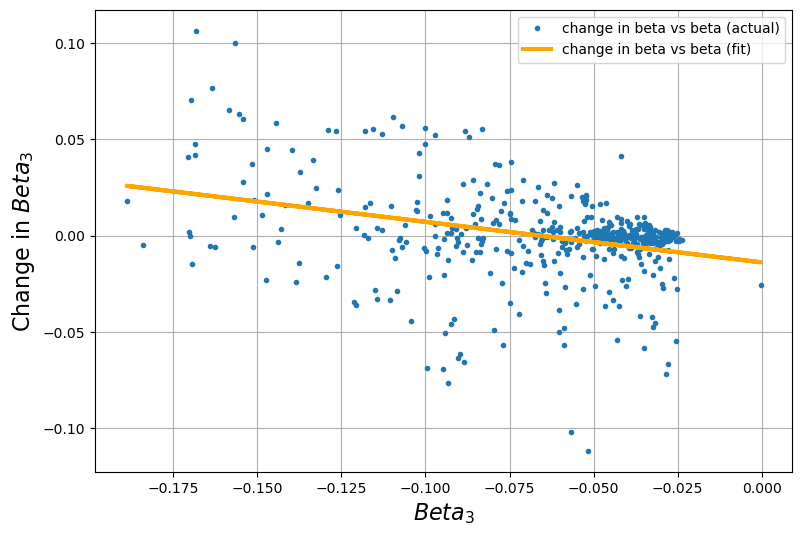

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-52.6485710216604
adf p-value= 4.232552143543253e-06


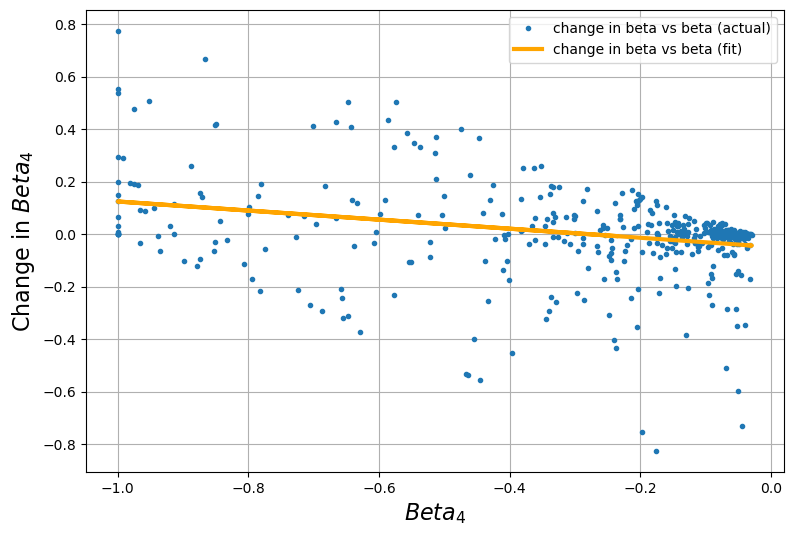

-43.13080380602715
adf p-value= 0.00013648058955117285


In [39]:
paths = np.array(betas).transpose().astype(float)
dx = np.diff(paths, axis=1)
x = paths[:,:-1]

for i in range(4):
    dxfitcoefs = np.polyfit(x[i,:], dx[i,:],deg = 1)
    dxfit = np.polyval(dxfitcoefs, x[i,:])

    plt.figure(figsize=(9, 6))
    plt.grid(True)
    plt.plot(x[i,:], dx[i,:], '.', label = 'change in beta vs beta (actual)')
    plt.plot(x[i,:], dxfit, '-', label = 'change in beta vs beta (fit)', color='orange', linewidth=3)
    plt.ylabel(f'Change in $Beta_{i+1}$', fontsize=16)
    plt.xlabel(f'$Beta_{i+1}$', fontsize=16)
    plt.legend(loc = 'best')
    plt.savefig(f'adf_beta{i+1}.eps', format='eps')
    plt.show()

    dt = 1.0/250
    print(dxfitcoefs[0]/dt)
    print('adf p-value=', adfuller(paths[i,:], maxlag=1)[1])

## Investigate the Hurst exponent for detecting mean-reversion

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


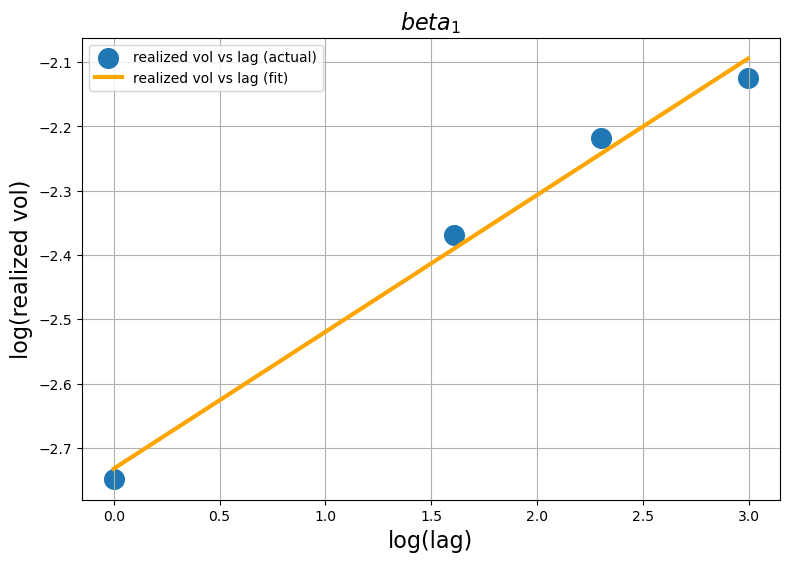

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Hurst=0.21291487618336605


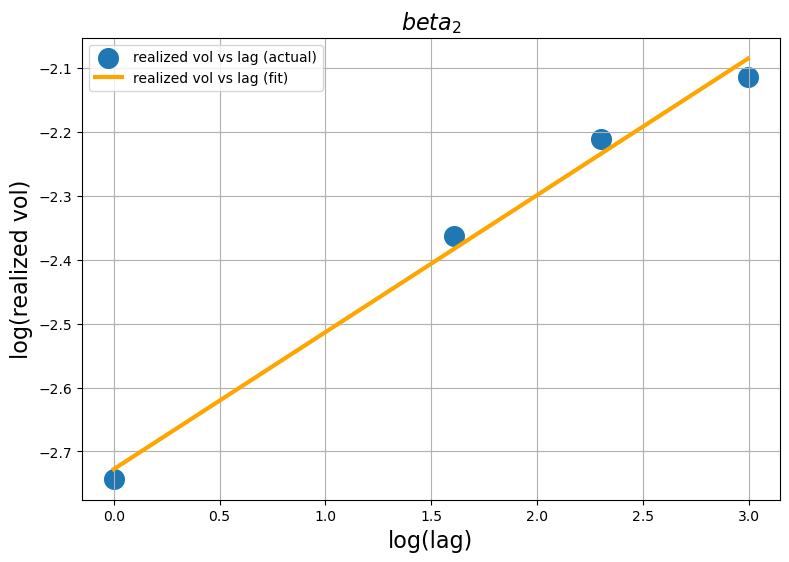

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Hurst=0.2144951011138903


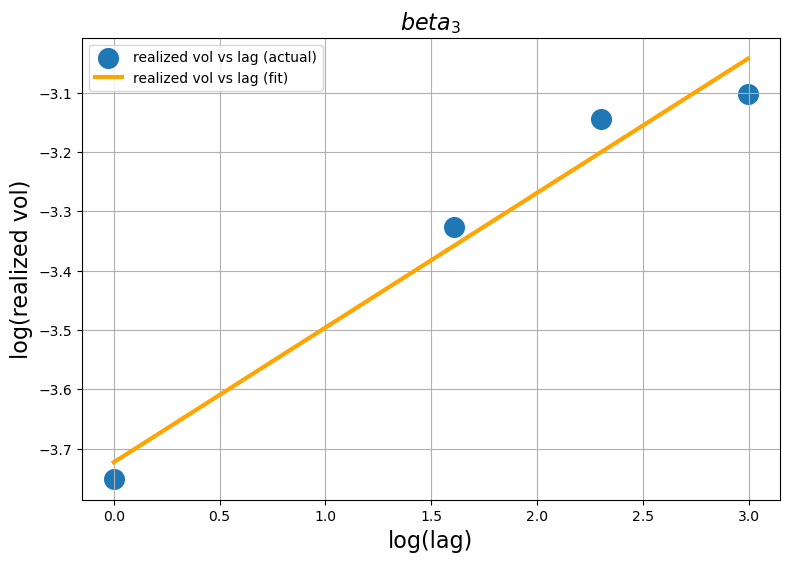

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Hurst=0.22718744754271747


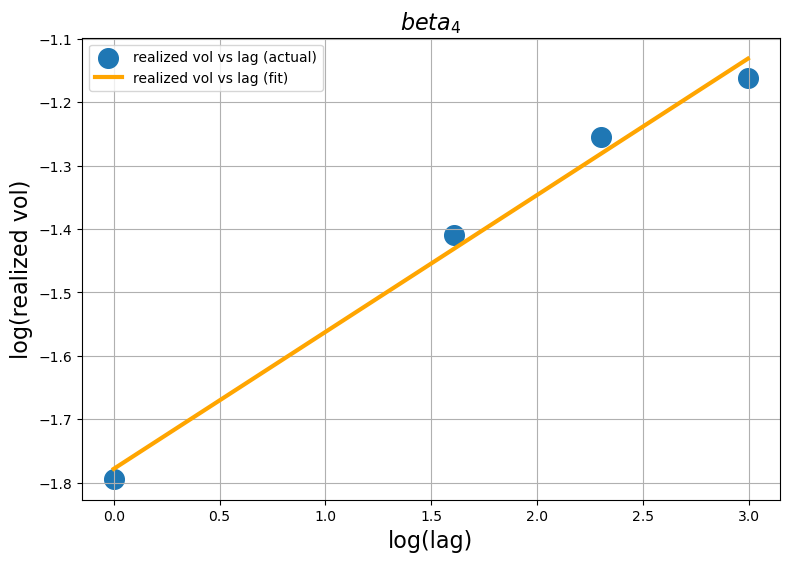

Hurst=0.2158540523826075


In [40]:
plot_lags = np.array([1, 5,10,20])
paths_to_plot = np.array(betas).transpose().astype(float)
for pathidx in range(4):
    tau = [np.std(np.subtract(paths_to_plot[pathidx,lag:], paths_to_plot[pathidx,:-lag])) for lag in plot_lags]
    poly = np.polyfit(np.log(plot_lags), np.log(tau), 1)
    tau_fit = np.polyval(poly, np.log(plot_lags))
    plt.figure(figsize=(9, 6))
    plt.grid(True)
    plt.scatter(np.log(plot_lags), np.log(tau), label = 'realized vol vs lag (actual)', s=200)
    plt.plot(np.log(plot_lags), tau_fit, '-', label = 'realized vol vs lag (fit)', linewidth=3, color='orange')
    plt.xlabel('log(lag)', fontsize=16)
    plt.ylabel('log(realized vol)', fontsize=16)
    plt.legend(loc='best')
    plt.title(f'$beta_{pathidx+1}$', fontsize=16)
    plt.savefig(f'hurst_{pathidx+1}.eps', format='eps')
    plt.show()
    print(f'Hurst={poly[0]}')

In [41]:
def calc_hurst_exponent(xs, lags = None):
    """
    adapted from https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing/
    Returns the Hurst Exponent of the time series vector xs
    In our version xs is npaths x ndays array
    and output is an npaths array

    Parameters
    ----------
    xs : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    if lags is None:
        lags = [1, 5,10,20]
    lags = np.asarray(lags)

    npaths = xs.shape[0]
    hs = np.zeros(npaths)
    for pathidx in range(npaths):
        # Calculate the array of the variances of the lagged differences
        vols = [np.std(np.subtract(xs[pathidx,lag:], xs[pathidx,:-lag])) for lag in lags]

        # Use a linear fit to estimate the Hurst Exponent
        poly = np.polyfit(np.log(lags), np.log(vols), 1)
#         poly = np.polyfit(lags, np.log(vols), 1)
        hs[pathidx] = poly[0]

    # Return the Hurst exponents from the polyfit output per path
    return hs
hursts = calc_hurst_exponent(paths_to_plot)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


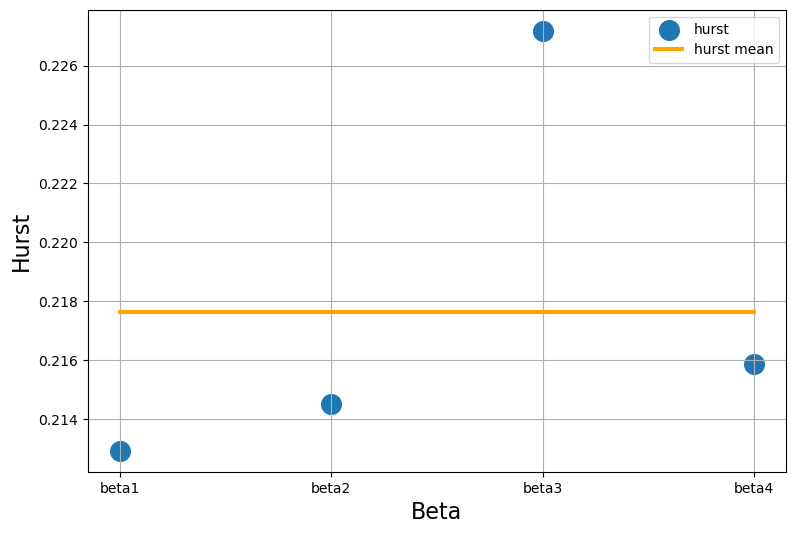

0.21761286930564533


In [42]:
plt.figure(figsize=(9, 6))
plt.grid(True)
plt.scatter(range(1, 5),hursts, label = 'hurst', marker='o', s=200)
plt.plot(range(1, 5),hursts.mean()*np.ones_like(hursts), color='orange', label = 'hurst mean', linewidth=3)
plt.xticks(range(1, 5), [f'beta{i}' for i in range(1, 5)]) 
plt.xlabel('Beta', fontsize=16)
plt.ylabel('Hurst', fontsize=16)
plt.legend(loc = 'best')
plt.savefig('hurst.eps', format='eps')
plt.show()
print(hursts.mean())